# <p style="text-align:center;"> Movie Recommendation Challenge <p>
The internet has changed how we consume content. We have moved from using compact disks to access content such as movies and series to having access to a catalog with thousands of movies/series through streaming services such as Netflix and Showmax. This is where the paradox of choice kicks in, because we have so many options to choose from it has become increasingly difficult to decide what to watch. To address this issue, companies need to taylor their services to the consumption habits of customers and one way of doing this is through recommendation engines. This project aims to construct a robust movie recommendation algorithm that can predict how a user will rate a movie based on their consumption traits and preferences.

<div style="width:100%;text-align: center;"> <img align=middle src="https://raw.githubusercontent.com/nkonyanihlulani/pictures/main/329633.jpg" style="height:500px;margin-top:3rem;"> </div>

## Table of Contents
* [List of All Files in Directory](#section-one)
* [Installing Packages](#section-two)
* [Reading in Data and Overview](#section-three)
* [Exploratory Data Analysis](#section-four)
* [Modelling Phase](#section-five)
 * [Collaborative Filtering](#subsection-one)
     * [Data Preprocessing]((#subsubsection-one)
     * [Model Comparison](#subsubsection-two)
     * [Model Tuning and Evaluation](#subsubsection-three)
     * [Train Best Model on Full Dataset](#subsubsection-four)
     * [Making Submission](#subsubsection-five)
 * [Content Based Approach](#subsection-two)
* [Conclusion](#section-seven)
* [References](#section-eight)


<a id="section-one"></a>
## List of All Files in Directory

In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        
        print(os.path.join(dirname, filename))

/kaggle/input/edsa-movie-recommendation-challenge/sample_submission.csv
/kaggle/input/edsa-movie-recommendation-challenge/movies.csv
/kaggle/input/edsa-movie-recommendation-challenge/imdb_data.csv
/kaggle/input/edsa-movie-recommendation-challenge/genome_tags.csv
/kaggle/input/edsa-movie-recommendation-challenge/genome_scores.csv
/kaggle/input/edsa-movie-recommendation-challenge/train.csv
/kaggle/input/edsa-movie-recommendation-challenge/test.csv
/kaggle/input/edsa-movie-recommendation-challenge/tags.csv
/kaggle/input/edsa-movie-recommendation-challenge/links.csv


<a id="section-two"></a>
## Installing Packages

In [2]:
# Install packages here
# !pip install --upgrade pip

# !pip install comet_ml

# Packages for data processing
import numpy as np
import pandas as pd
import gc


import datetime
from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from scipy.sparse import csr_matrix
import scipy as sp



# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline
sns.set_theme()

# Packages for modeling
from surprise import Reader
from surprise import Dataset
from surprise import KNNWithMeans
from surprise import KNNBasic
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise import KNNBaseline
from surprise import NormalPredictor
from surprise import BaselineOnly
from sklearn.metrics.pairwise import linear_kernel
import heapq

# Packages for model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from time import time

# Package to suppress warnings
import warnings
warnings.filterwarnings("ignore")

#running experiments
# from comet_ml import Experiment
# experiment = Experiment(api_key='jOPX4ya8LjBTfsqRhitiRrIUo', project_name="adj", workspace="phaks323")

# Packages for saving models
import pickle

<a id="section-three"></a>
## Reading in Data and Overview

This dataset consists of several million 5-star ratings obtained from users of the online MovieLens movie recommendation service. The MovieLens dataset has long been used by industry and academic researchers to improve the performance of explicitly-based recommender systems, and now you get to as well!

For this Predict, we'll be using a special version of the MovieLens dataset which has enriched with additional data, and resampled for fair evaluation purposes.

The data for the MovieLens dataset is maintained by the GroupLens research group in the Department of Computer Science and Engineering at the University of Minnesota. Additional movie content data was legally scraped from IMDB

In [3]:
df_sample_submission = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/sample_submission.csv')
df_movies = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/movies.csv')
df_imdb = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/imdb_data.csv')
df_genome_scores = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/genome_scores.csv')
df_genome_tags = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/genome_tags.csv')
df_train = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/train.csv')
df_test = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/test.csv')
df_tags = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/tags.csv')
df_links = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/links.csv')

#### Train Data

In [4]:
df_train.head()

userId  movieId  rating   timestamp
0    5163    57669     4.0  1518349992
1  106343        5     4.5  1206238739
2  146790     5459     5.0  1076215539
3  106362    32296     2.0  1423042565
4    9041      366     3.0   833375837

The train dataframe has 4 columns:
* userId - Id assigned to each user in our dataset
* movieId - Id assigned to each movie title
* rating - rating assigned to a specific movie by a specific user.
 * ratings are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars)
* timestamp - represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.

In [5]:
print('df_train has '+str(len(df_train))+' observations')

df_train has 10000038 observations


#### Movies Data

In [6]:
df_movies.tail()

movieId                           title                  genres
62418   209157                       We (2018)                   Drama
62419   209159       Window of the Soul (2001)             Documentary
62420   209163                Bad Poems (2018)            Comedy|Drama
62421   209169             A Girl Thing (2001)      (no genres listed)
62422   209171  Women of Devil's Island (1962)  Action|Adventure|Drama

This movies dataframe has 3 columns namely:
* movieId
* title of the movie
* genres

In [7]:
#getting dimensions
print("df_movies "+ str(len(df_movies))+" observations.")

df_movies 62423 observations.


#### IMDB Data

In [8]:
df_imdb.head()

movieId                                         title_cast  \
0        1  Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...   
1        2  Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...   
2        3  Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...   
3        4  Whitney Houston|Angela Bassett|Loretta Devine|...   
4        5  Steve Martin|Diane Keaton|Martin Short|Kimberl...   

              director  runtime       budget  \
0        John Lasseter     81.0  $30,000,000   
1   Jonathan Hensleigh    104.0  $65,000,000   
2  Mark Steven Johnson    101.0  $25,000,000   
3       Terry McMillan    124.0  $16,000,000   
4       Albert Hackett    106.0  $30,000,000   

                                       plot_keywords  
0                   toy|rivalry|cowboy|cgi animation  
1                   board game|adventurer|fight|game  
2                         boat|lake|neighbor|rivalry  
3  black american|husband wife relationship|betra...  
4                    fatherhood|doberman|dog|mansion

The imdb dataframe has 5 columns:
* movieId
* title_cast 
* Directors names
* runtime
* budget
* plot_keywords

In [9]:
df_imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movieId        27278 non-null  int64  
 1   title_cast     17210 non-null  object 
 2   director       17404 non-null  object 
 3   runtime        15189 non-null  float64
 4   budget         7906 non-null   object 
 5   plot_keywords  16200 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.2+ MB


df_imdb has 27279 observations and aome columns contain missing values

#### Genome Tags & Scores
Tag genome encodes how strongly movies exhibit particular properties represented by tags. We looked at both the df_genome_tags and df_genome_scores, starting with the former

In [10]:
df_genome_tags.head()

tagId           tag
0      1           007
1      2  007 (series)
2      3  18th century
3      4         1920s
4      5         1930s

This dataframe has two columns:
* tagId
* tag -description of the tags

In [11]:
print("df_genome_tags has",len(df_genome_tags),"observations")

df_genome_tags has 1128 observations


In [12]:
df_genome_scores.head()

movieId  tagId  relevance
0        1      1    0.02875
1        1      2    0.02375
2        1      3    0.06250
3        1      4    0.07575
4        1      5    0.14075

This dataframe has 3 columns:
* movieId
* tagId
* relevance - computed using a machine learning algorithm on user-contributed content including tags, ratings, and textual reviews

This dataframe will be linked with df_train through the movied

In [13]:
print("df_genome_scores has",len(df_genome_scores),"observations")

df_genome_scores has 15584448 observations


#### Tags
User supplied tags for each movie at a specific timestamp.

In [14]:
df_tags.head()

userId  movieId               tag   timestamp
0       3      260           classic  1439472355
1       3      260            sci-fi  1439472256
2       4     1732       dark comedy  1573943598
3       4     1732    great dialogue  1573943604
4       4     7569  so bad it's good  1573943455

df_tags has 4 columns:
* userId
* movieId
* tag - tag supplied by user
* timestamp - specific timestamp associated with the tag

In [15]:
print("df_tags has",len(df_tags),"observations")

df_tags has 1093360 observations


#### Test Data

In [16]:
df_test.head()

userId  movieId
0       1     2011
1       1     4144
2       1     5767
3       1     6711
4       1     7318

df_train has two columns:
* userId
* movieId

In [17]:
print("The training set has", str(len(df_test)),"observations")

The training set has 5000019 observations


#### Sample Submission

In [18]:
df_sample_submission.head()

Id  rating
0  1_2011     1.0
1  1_4144     1.0
2  1_5767     1.0
3  1_6711     1.0
4  1_7318     1.0

<a id="section-four"></a>
## Exploratory Data Analysis
Discovery phase and data understanding

#### Distribution of Ratings

Descriptive Statistics

In [19]:
pd.DataFrame(df_train['rating'].describe().apply(lambda x: round(x,2)), 
             columns=['rating']).rename(columns={'rating':'Statistic'})

Statistic
count  10000038.00
mean          3.53
std           1.06
min           0.50
25%           3.00
50%           3.50
75%           4.00
max           5.00

* The average rating of all the movies in our dataset is 3.53.
* The median (middle value) is 3.5 which is slighly less than the mean.
* The standard deviation (spread around the average) is  1.06.
* The lowest rating is 0.5 and the highest rating is 5.
* The lower quantile (bottom 25 cut-off point) is 3 and the upper quantile (top 25 cut-off point) is 4.


In [20]:
#creating a dataframe with ratings and their counts

rating_counts = df_train.groupby(['rating']).count().reset_index().rename(columns={'userId':'count'})[['rating','count']]

We use the dataframe above to obtain a bargraph showing the distribution of ratings

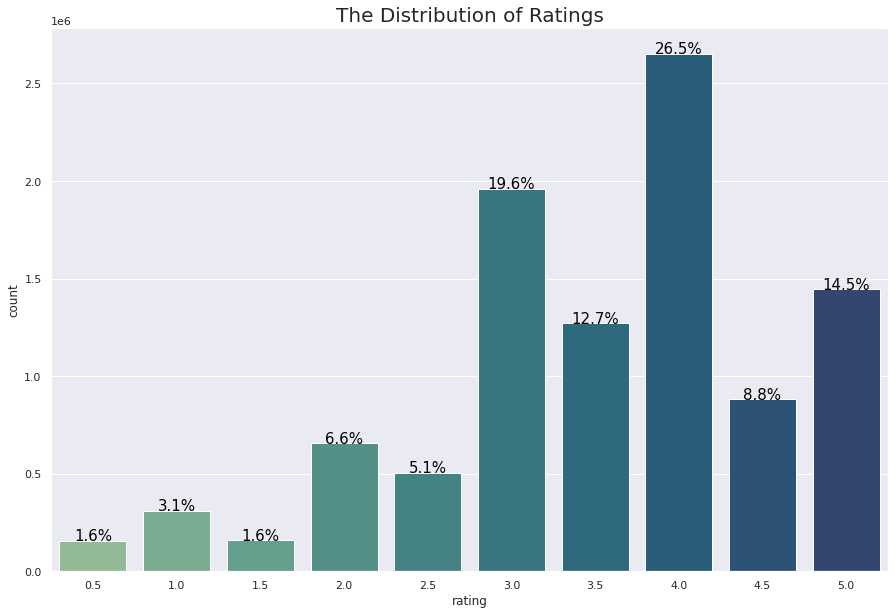

In [21]:
#Plot showing the distribution of counts
plot = plt.figure(figsize=(15, 10))
a = sns.barplot(x='rating',y='count',data=rating_counts,palette='crest')
a.set_title('The Distribution of Ratings',fontsize=20)

#Obtaining percentages on top of bars
n_obs = [i.get_height() for i in a.patches]
total = sum(n_obs)

for i in a.patches:
    # get_x pulls left or right; get_height pushes up or down
    a.text(i.get_x()+i.get_width() / 2, i.get_height()+0.5, \
            str(round((i.get_height()/total)*100, 1))+'%', fontsize=15,
                color='black',ha='center')
    
plt.show()


* The most common rating given by users (26.5%) is 4. 
* The ratings appear to be skewed to the left (evidenced by the long tail to the left). This means that there are a few movies who received lower ratings compared to those that received higher ratings


The we calculated the coefficient of skewness to check our above findings.

In [22]:
#calcuting skew
print('The Coefficient of Skewness is : '+str(rating_counts['count'].skew()))

The Coefficient of Skewness is : 0.9316640025763425


This contradicts with our suspicion that the distribution is negatively skewed. The contradiction can be explained by the fact that the distribution appears to have 2 peaks (slightly bimodal).

In [23]:
del rating_counts
gc.collect()

48

#### Number of Unique Users

In [24]:
print('Train df has '+str(df_train['userId'].nunique())+' unique users')

Train df has 162541 unique users


#### Rating by Number of Ratings

We plotted the average ratings of movies as a functions of how many times they were rated

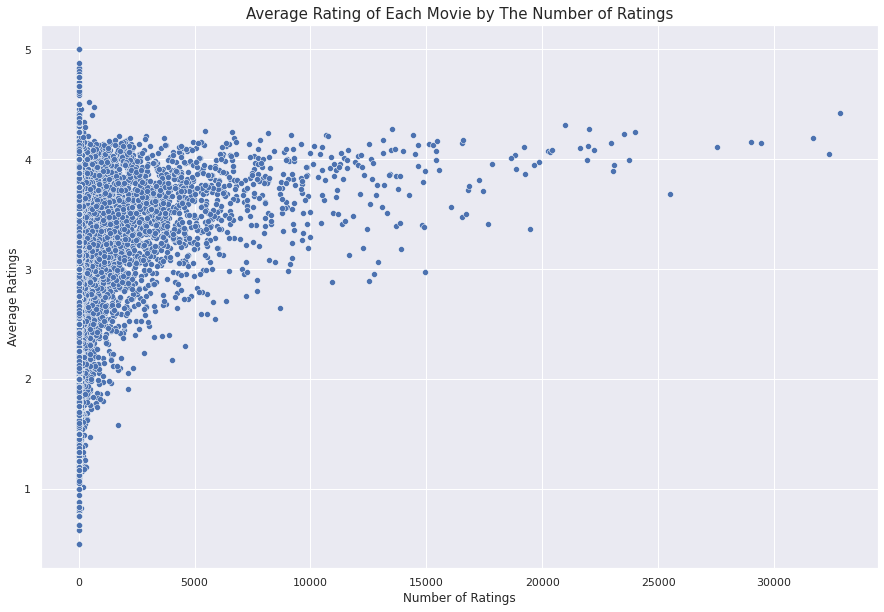

In [25]:
#mean ratings of movies
ave_movie_rating = df_train.groupby('movieId')['rating'].mean().reset_index(drop=True)

#counts according to movie id
count_movies = df_train.groupby('movieId')['rating'].count().reset_index(drop=True) #

plot = plt.figure(figsize=(15, 10))
plt.title("Average Rating of Each Movie by The Number of Ratings", fontsize=15)
a = sns.scatterplot(x=count_movies,y=ave_movie_rating,palette='crest')
a.set_xlabel('Number of Ratings')
a.set_ylabel('Average Ratings')

plt.show()

* The ratings of movies that have a smaller number of ratings are widely spread. A possible explanation for this would be law of large numbers, it dictates that movies that are frequently rated produce more stable estimates of the true average rating.

#### Most common Genres

In [26]:
# Create dataframe containing only the movieId and genres
movies_genres = pd.DataFrame(df_movies[['movieId', 'genres']],
                             columns=['movieId', 'genres'])

# Split genres seperated by "|" and create a list containing the genres allocated to each movie
movies_genres.genres = movies_genres.genres.apply(lambda x: x.split('|'))

# Create expanded dataframe where each movie-genre combination is in a seperate row
movies_genres = pd.DataFrame([(tup.movieId, d) for tup in movies_genres.itertuples() for d in tup.genres],
                             columns=['movieId', 'genres'])


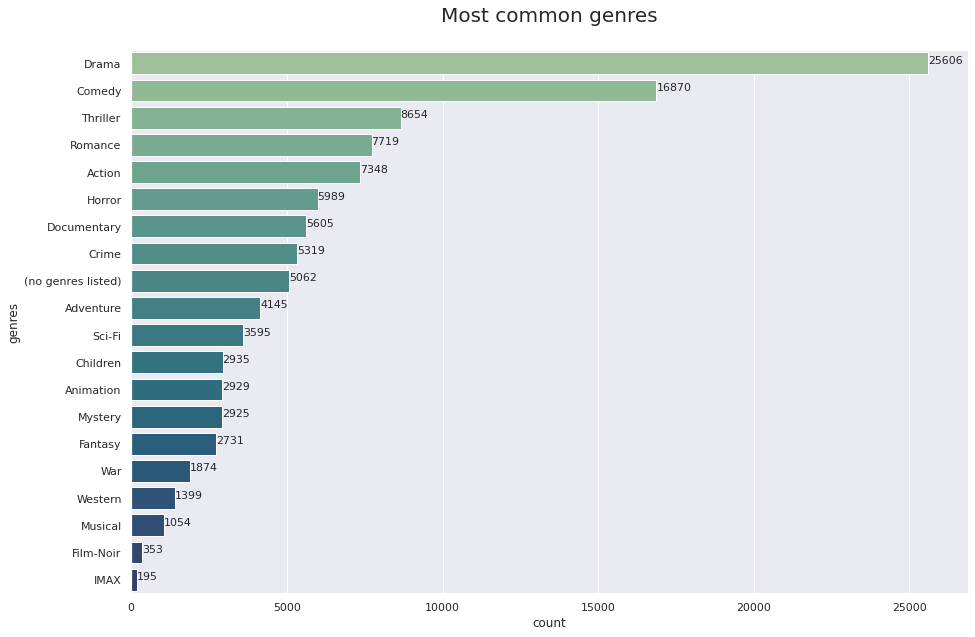

In [27]:
# Plot the genres from most common to least common
plot = plt.figure(figsize=(15, 10))
plt.title('Most common genres\n', fontsize=20)
a = sns.countplot(y="genres", data=movies_genres,
              order=movies_genres['genres'].value_counts(ascending=False).index,
              palette='crest')

for p in a.patches:
        value = '{:.0f}'.format(p.get_width())
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        a.annotate(value, (x, y),fontsize=11)
plt.show()


* The top 3 occuring genres are Drama, Comedy, and Thrillers.
* Musical, Film-Noir and IMAX movies were the least represented in our dataset


#### Average Rating Per Genre

In [28]:
#joining train_df and movie_genres
rating_genre = pd.merge(df_train,movies_genres, on='movieId',how='left')

#dataframe of average rating according to genr
ave_per_genre = rating_genre.groupby(['genres'])['rating'].mean().reset_index()

#sorting values from largest to smallest
ave_per_genre = ave_per_genre.sort_values(by='rating',ascending=False).reset_index()

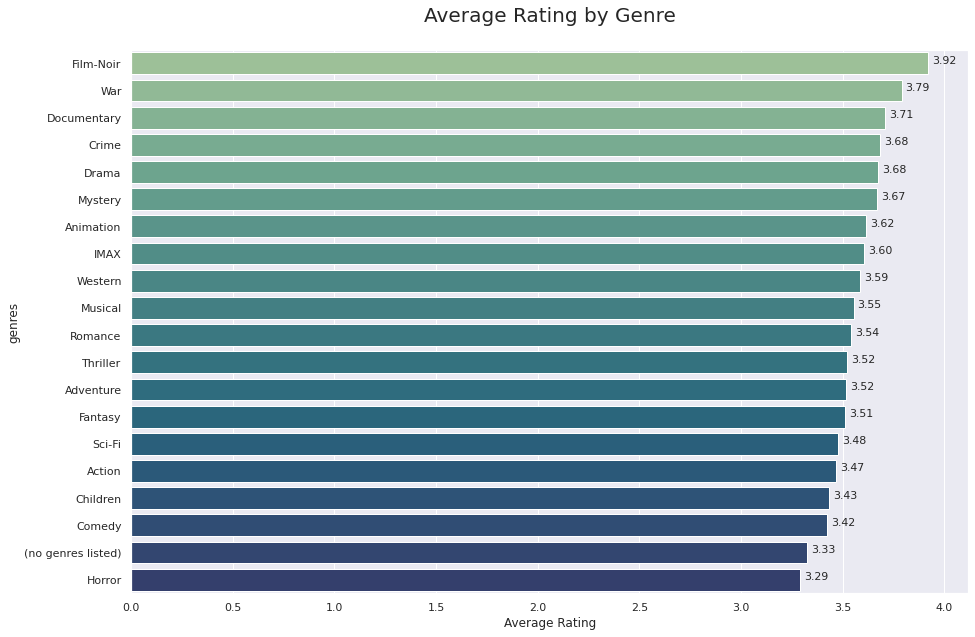

In [29]:
#horizontal barchart plotting based on the above
plot = plt.figure(figsize=(15, 10))
plt.title('Average Rating by Genre\n', fontsize=20)
a = sns.barplot(x='rating',y="genres", data=ave_per_genre,
              palette='crest')

#creating horizontal label
a.set_xlabel('Average Rating')

#adding annotations to bar
for p in a.patches:
        value = '{:.2f}'.format(p.get_width())
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        a.annotate(value, (x, y),fontsize=11)
plt.show()

* The average ratings according to genre were in a narrow range 
* Film-Noirs, War Movies , and Documentaries recieved the highest average ratings.
* Film-Noirs received the highest rating even though they are the second lowest reviewed movies.
* Comedies and Horrors received the lowest ratings. Possible explanation: too predictable?
* Comedies recieved the second lowest average rating even though they were in the top 2 reviewed movies.

In [30]:
del movies_genres, rating_genre, ave_per_genre, plot, a

gc.collect()

8015

#### Do Budget and/or Runtime Affect Ratings


In [31]:
#Merging the dataframe to obtain the budget
df_budget = pd.merge(df_train,df_imdb[['movieId','budget']], on ='movieId', how='left')

#string the dollors
pattern = r'\$'
df_budget['budget'] = df_budget['budget'].apply(lambda x: re.sub(pattern, '', str(x)))

#stripping the commas
pattern = r'\,'
df_budget['budget'] = df_budget['budget'].apply(lambda x: re.sub(pattern, '', str(x)))

#convert to numerical value
df_budget['budget'] = pd.to_numeric(df_budget['budget'], errors='coerce')

#budget according to rating
budget_rating = df_budget.groupby(['rating'])['budget'].mean().reset_index()

In [32]:
#merging dataframe to obtain runtime
df_runtime = pd.merge(df_train,df_imdb[['movieId','runtime']], on ='movieId', how='left')

#budget according to rating 
runtime_rating = df_runtime.groupby(['rating'])['runtime'].mean().reset_index()

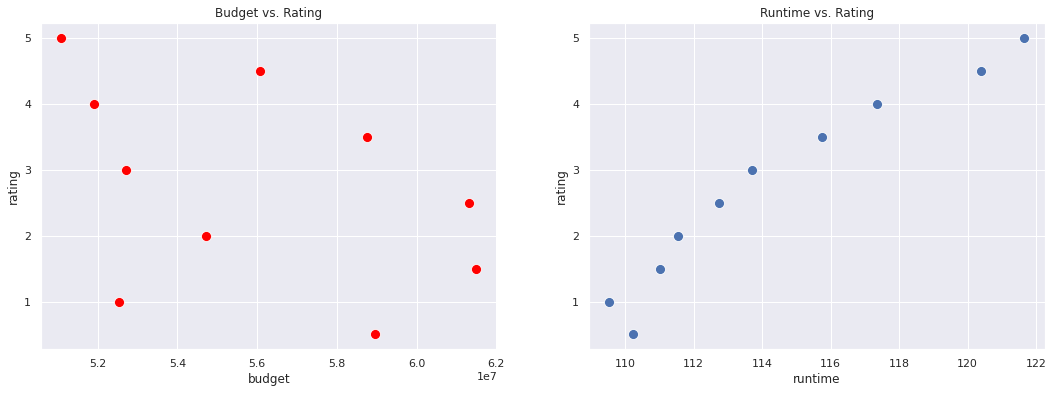

In [33]:
#scatter plot of rating and  Budget
fig, axes = plt.subplots(1,2, figsize=(18, 6), squeeze=False)

plot1 = sns.scatterplot(x='budget', y='rating', data =budget_rating, s=100, color='red', ax=axes[0,0])
plot2 = sns.scatterplot(x='runtime',y='rating', data=runtime_rating, s=100, ax =axes[0,1])
plot1.set_title('Budget vs. Rating')
plot2.set_title('Runtime vs. Rating')

plt.show()

* It seems that ther is no obvious relationship between the budget of the movie and the rating
* With the exception of one point, as runtime increases the rating also increase in a linear fashion

In [34]:
del df_runtime, df_budget, budget_rating, runtime_rating, plot1, plot2, fig,axes
gc.collect()

5714

#### Most Rated Movies
This can be used as a proxy for how many people have watched the movies

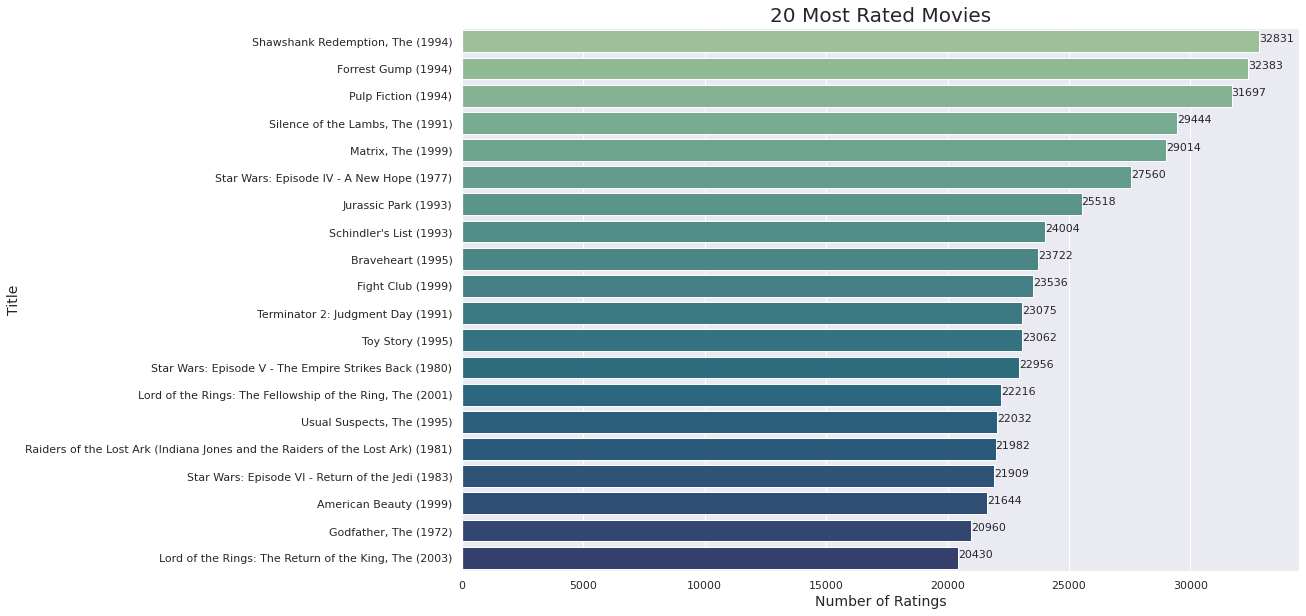

In [35]:
movies = pd.merge(df_train, df_movies[['movieId','title']], on='movieId', how="left")
movie_count = movies.groupby(['title'])['rating'].count().reset_index().rename(columns={'rating':'count'})

plot = plt.figure(figsize=(15, 10))
plt.title('20 Most Rated Movies', fontsize=20)
a = sns.barplot(x='count',
                y="title", 
                data=movie_count.sort_values(by='count',ascending =False).head(20),
                palette='crest')

#creating horizontal label
a.set_xlabel('Number of Ratings', fontsize=14)
a.set_ylabel('Title', fontsize=14)

#adding annotations to bar
for p in a.patches:
        value = int(p.get_width())
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        a.annotate(value, (x, y),fontsize=11)
plt.show()

Most of the movies on this list are critically acclaimed. The most reviewed movie "The Shawshank Redemption" holds the number one spot on the imdb top 250 movies of all time. The same applies all the titles on this list, most of them are in the 30. Here's a link to the full list [click](https://www.imdb.com/search/title/?groups=top_250&sort=user_rating)

In [36]:
del movies, movie_count, plot, a
gc.collect()

7012

#### Filtering Movies According To Number of Ratings
We filters the movies by setting a floor on the number of ratings. This is to ensure a fair comparison between the lead actors and between directors.


In [37]:
min_movie_ratings = 500
filter_movies = df_train['movieId'].value_counts() > min_movie_ratings
filter_movies = filter_movies[filter_movies].index.tolist()
df_train_filtered = df_train[df_train['movieId'].isin(filter_movies)]
df_train_filtered.shape

(8634617, 4)

#### Top Rated Movies 

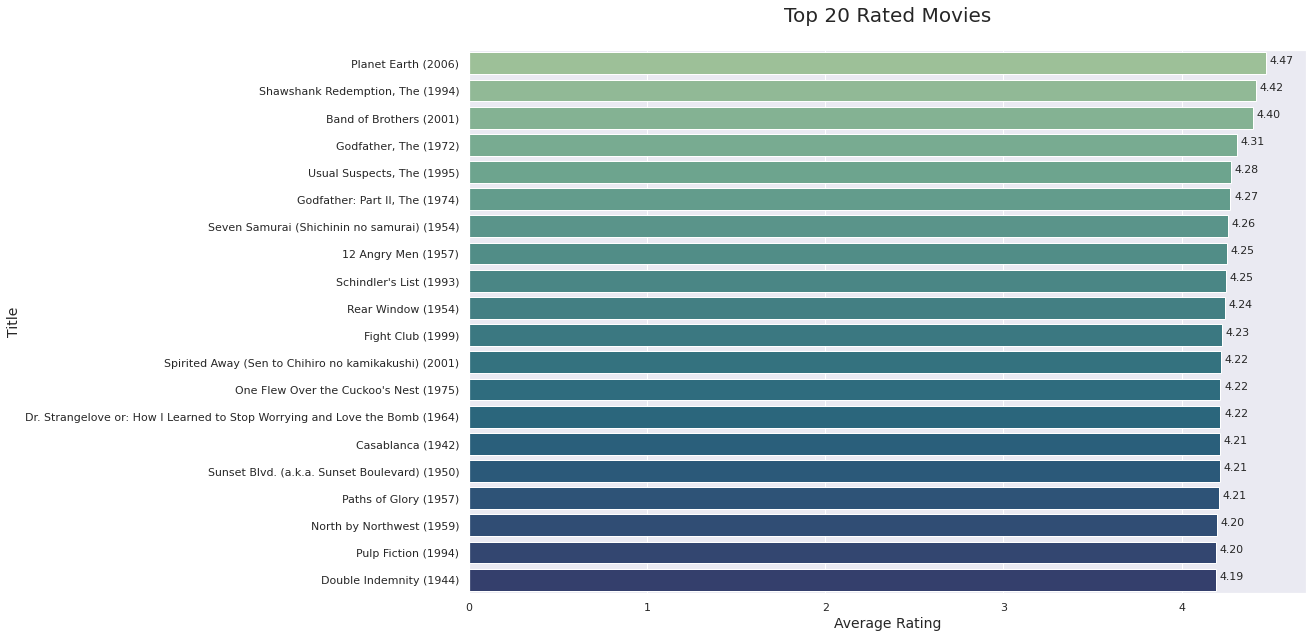

In [38]:
movie_rating_merge = pd.merge(df_train_filtered,df_movies[['movieId','title']],on='movieId', how='left')
movie_rating = movie_rating_merge.groupby('title')['rating'].mean().reset_index()

plot = plt.figure(figsize=(15, 10))
plt.title('Top 20 Rated Movies\n', fontsize=20)
a = sns.barplot(x='rating',
                y="title", 
                data=movie_rating.sort_values(by='rating',ascending =False).head(20),
                palette='crest')

#creating horizontal label
a.set_xlabel('Average Rating', fontsize=14)
a.set_ylabel('Title', fontsize=14)

#adding annotations to bar
for p in a.patches:
        value = '{:.2f}'.format(p.get_width())
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        a.annotate(value, (x, y),fontsize=11)
plt.show()

These movies correspond to those that are part of the imdb top 250 movies, they are critically acclaimed and our data confirms that. Movies like The Shawshank Redemption,The Godfather, The Usual Suspects,12 Angry Men and Schindler's List are examples of movies that appear on the top 20 of both lists. Click [here](https://www.imdb.com/search/title/?groups=top_250&sort=user_rating) to view the  imdb top 250 movies.

#### Worst Rated Movies

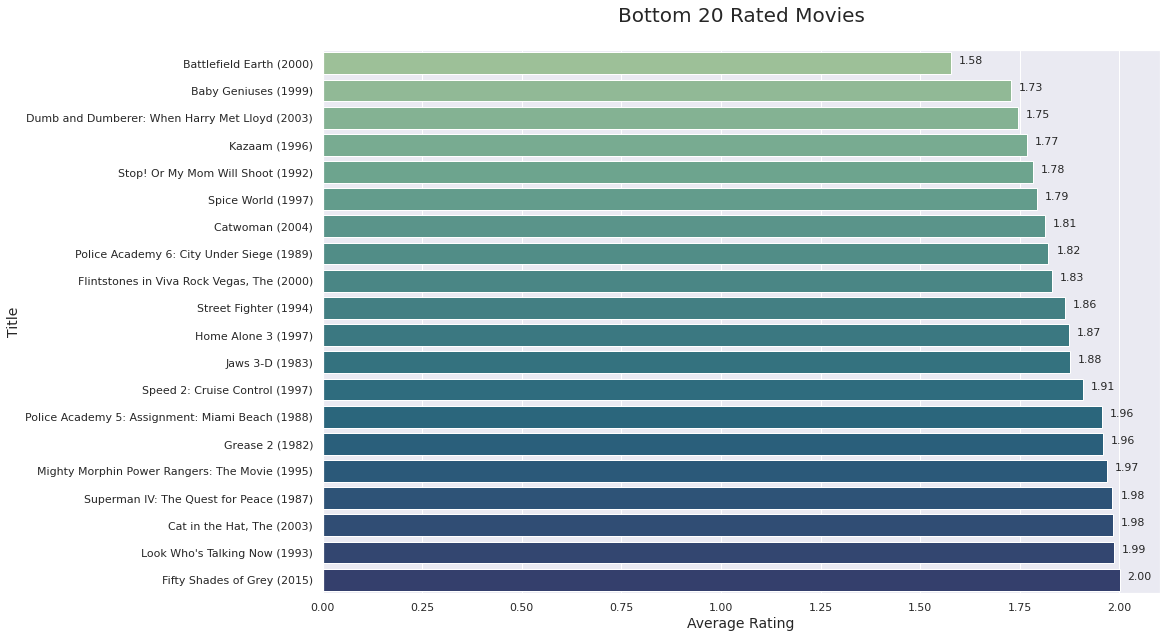

In [39]:
plot = plt.figure(figsize=(15, 10))
plt.title('Bottom 20 Rated Movies\n', fontsize=20)
a = sns.barplot(x='rating',
                y="title", 
                data=movie_rating.sort_values(by='rating').head(20),
                palette='crest')

#creating horizontal label
a.set_xlabel('Average Rating', fontsize=14)
a.set_ylabel('Title', fontsize=14)

#adding annotations to bar
for p in a.patches:
        value = '{:.2f}'.format(p.get_width())
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        a.annotate(value, (x, y),fontsize=11)
plt.show()

The bottom movies, since we limited our analysis to movies that recieved 500 ratings or more we get a list of familiar movies, an example "Stop! Or My Mom Will Shoot" which is the 3rd worst rated movies and is one of the lesser popular Sylvester Stallone movies, the comment that received the highest number on imdb of upvotes on imdb is "The story was corny, the plot was predictable. The supporting cast was lacking. This is not a thriller or an intelligent movie. It is a B comedy., at best." [link](https://www.imdb.com/title/tt0105477/?ref_=nv_sr_srsg_0) and this is reflected in the rating that it received. Other movies appearing on the list are titles such as Catwoman and Fifty Shades of Grey that are based on novels/comic books received lower ratings because the public/critics felt that they didn't capture the essence of the books/comics that they are based on.

In [40]:
del movie_rating_merge, movie_rating, plot, a
gc.collect()

13519

#### Top 50 Occurring Cast Members

In [41]:
#creating empty pandas dataframe
df_imdb_mod =pd.DataFrame({})

# joining the names and surnames
pattern = r'\s{1,}'
df_imdb_mod['title_cast'] = df_imdb['title_cast'].apply(lambda x: re.sub(pattern, '', str(x)))

pattern =r'\.|-'
df_imdb_mod['title_cast'] = df_imdb_mod['title_cast'].apply(lambda x: re.sub(pattern, '', str(x)))

#tokenizing the names and creating new column (for later)
df_imdb_mod['title_cast_sep'] = df_imdb_mod['title_cast'].str.split('|')

# joining the names back to strings
sep=" "
df_imdb_mod['title_cast'] = df_imdb_mod['title_cast_sep'].apply(lambda x : sep.join(x))

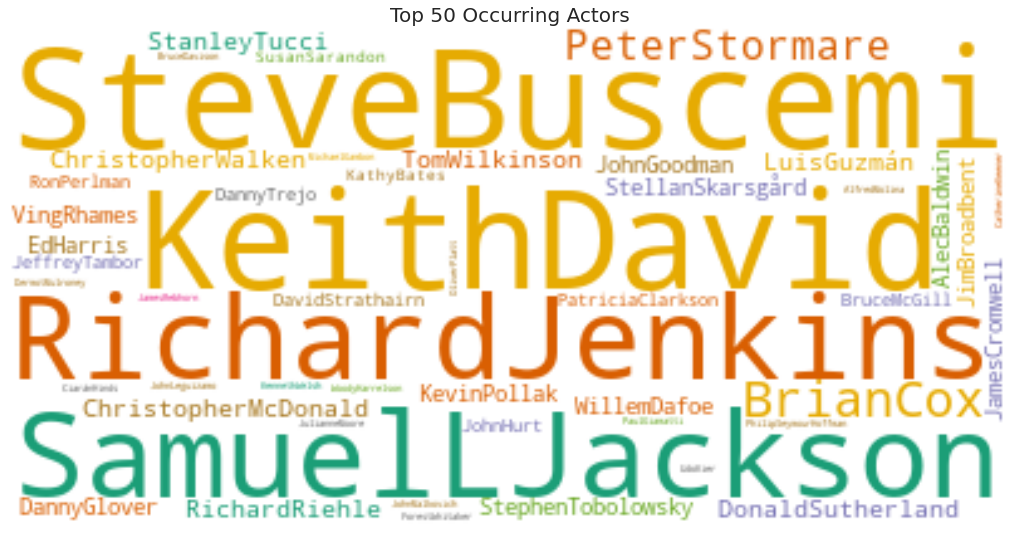

In [42]:
#string containing all cast members
all_cast ="".join([cast for cast in df_imdb_mod['title_cast']])

#creating wordcloud
fig = plt.figure(figsize=(18,10))

wc = WordCloud(background_color="white",
               colormap="Dark2", max_font_size=70,
               random_state=42,max_words=50)

wc.generate(all_cast)
plt.title('Top 50 Occurring Actors', fontsize=20)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Household names such as Steve Buscemi, who is credited with 166 acting roles accoring to imdb, click [here](https://www.imdb.com/name/nm0000114/) for full bio. Keith David is credited with 366 roles according to the same source, for more info : [here](https://www.imdb.com/name/nm0202966/?ref_=fn_al_nm_1). Richard Jenkins has 115 acting roles under his belt, full bio [here](https://www.imdb.com/name/nm0420955/?ref_=nv_sr_srsg_0). Samuel L. Jackson has 195 acting roles, full bio [here](https://www.imdb.com/name/nm0000168/?ref_=nv_sr_srsg_0).

#### Now Let us Look at The Lead Actors
We are assuming that the lead actor/actress is the first name mentioned on title credits. And the rating that the movie gets will be used as a proxy for the rating of the lead actor.


In [43]:
del all_cast, fig, wc
gc.collect()

2631

In [44]:
#joining df_train_filtered and part of df_imdb
cast_rating = pd.merge(df_train_filtered,df_imdb[['movieId','title_cast']],on='movieId', how='left')

#changing all the charactors to strings
cast_rating['title_cast'] = cast_rating['title_cast'].apply(lambda x: str(x))

# creating list containing cast, separator='|'
cast_rating['title_cast'] = cast_rating['title_cast'].str.split('|')

#taking the first actor of the lisr
cast_rating['lead_actor'] = cast_rating['title_cast'].apply(lambda x: x[0])

#dataframe containing the lead charactors and their average rating
lead_rating = pd.DataFrame({})
lead_rating = cast_rating.groupby('lead_actor')['rating'].mean().reset_index()


#### Top 10 Rated Lead Actors

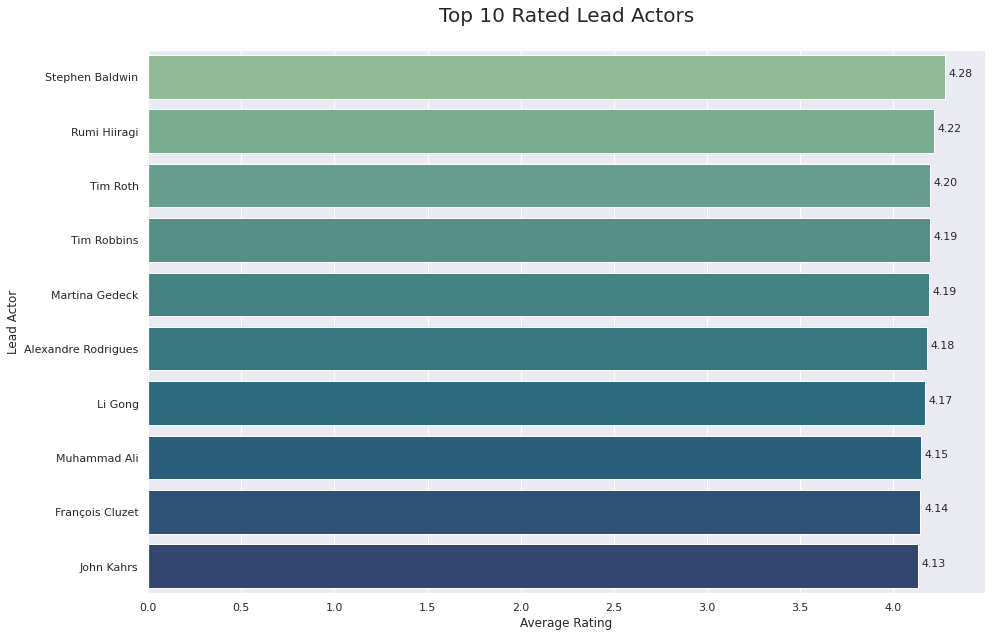

In [45]:
#average ratings of top 10 rated lead actors
plot = plt.figure(figsize=(15, 10))
plt.title('Top 10 Rated Lead Actors\n', fontsize=20)
a = sns.barplot(x='rating',
                y="lead_actor", 
                data=lead_rating.sort_values(by='rating',ascending =False).head(10),
                palette='crest')

#creating horizontal label
a.set_xlabel('Average Rating')
a.set_ylabel("Lead Actor")
#adding annotations to bar
for p in a.patches:
        value = '{:.2f}'.format(p.get_width())
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        a.annotate(value, (x, y),fontsize=11)
plt.show()

Stephen Baldwin highest rated lead actor according proxy that we used and is primarily known for the movie "The Usual Suspect", it has the 5th highest average rating (4.28/5) in our filtered dataset. Rumi Hiiragi is known for "Spirited Away" which is the 12th highest rated movie in our filtered dataset. Tim Roth appeared in "Pulp Fiction" which is the 19th highest rated movie.

#### Bottom 10  Lead Actors

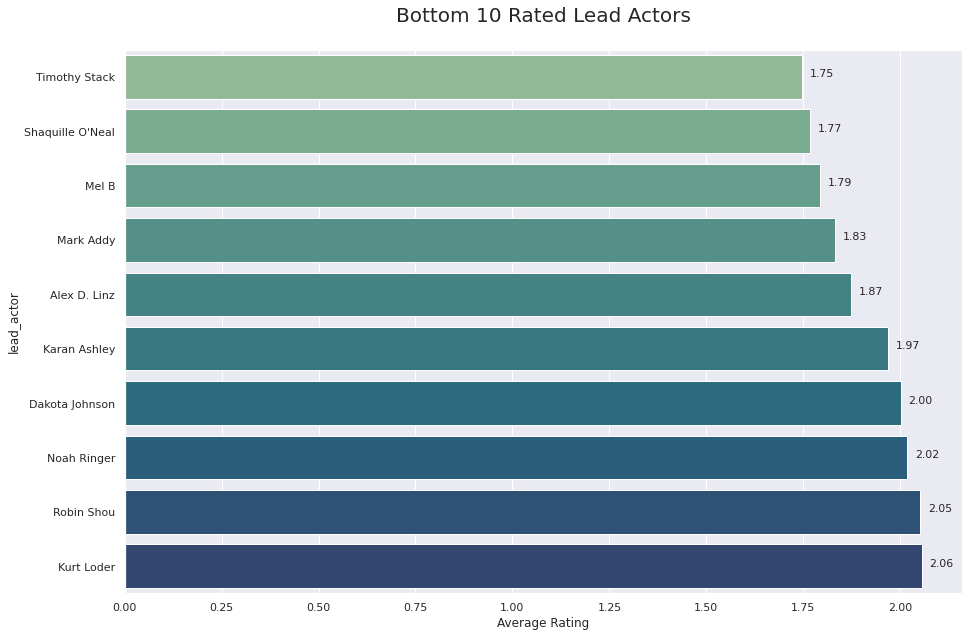

In [46]:
#average ratings of bottom 10 rated lead actors
plot = plt.figure(figsize=(15, 10))
plt.title('Bottom 10 Rated Lead Actors\n', fontsize=20)
a = sns.barplot(x='rating',
                y="lead_actor", 
                data=lead_rating.sort_values(by='rating').head(10),
                palette='crest')

#creating horizontal label
a.set_xlabel('Average Rating')

#adding annotations to bar
for p in a.patches:
        value = '{:.2f}'.format(p.get_width())
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        a.annotate(value, (x, y),fontsize=11)
plt.show()

Shaquile O'Neal is the second bottom 10 rated actor according to the proxy and known for the movie "Kazaam", with an average rating of 1.77 in our filtered dataset. Mel B is the third bottom rated actor and known for the movie "Spice World", with average rating of 1.79. Mark Addy is the forth bottom rated actor and known for "Flintstones in  Viva Rock in Vegas", with the average rating of 1.83.

In [47]:
del cast_rating , lead_rating, plot, a
gc.collect()

11739

#### Most Frequently Occurring Directors

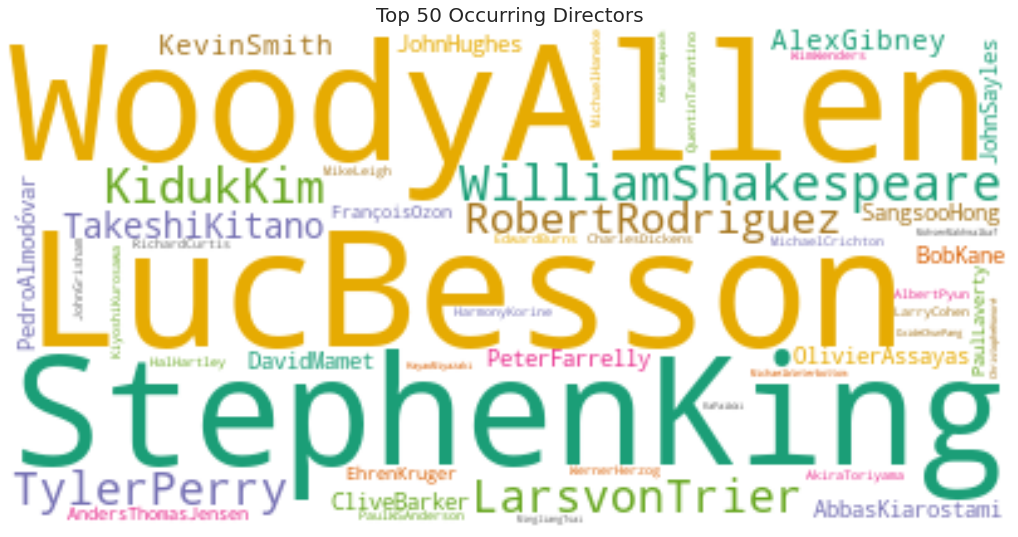

In [48]:
#joining names and surnames
pattern = r'\s{1,}'
df_imdb_mod['director'] = df_imdb['director'].apply(lambda x: re.sub(pattern, '', str(x)))

# removing commas and dashes
pattern = r'\.|\-'
df_imdb_mod['director'] = df_imdb_mod['director'].apply(lambda x: re.sub(pattern, '', str(x)))

directors = ' '.join([str(d) for d in df_imdb_mod['director']])

#creating wordcloud
fig = plt.figure(figsize=(18,10))
ign =['nan','Seefullsummary'] 
wc = WordCloud(stopwords=ign, background_color="white",
               colormap="Dark2", max_font_size=70,
               random_state=42,max_words=50)

wc.generate(directors)
plt.title('Top 50 Occurring Directors', fontsize=20)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

We get prominent directors such as Woody Allen, who has directed 55 movies over the span of his career according to imdb, for boi click [here](https://www.imdb.com/name/nm0000095/).
        Luc Besson is has directed over 65 movies/series according to imdb, for bio click [here](https://www.imdb.com/name/nm0000108/?ref_=nv_sr_srsg_0). 
        Stephen King is also a household name and has directed 15 movies/screenplays and has 325 credits as a writer, for bio click [here](https://www.imdb.com/name/nm0000175/?ref_=nv_sr_srsg_0).

In [49]:
del df_imdb_mod, directors, fig, wc
gc.collect()

2617

#### Now Let Us Look at The Top 10 Rated Directors

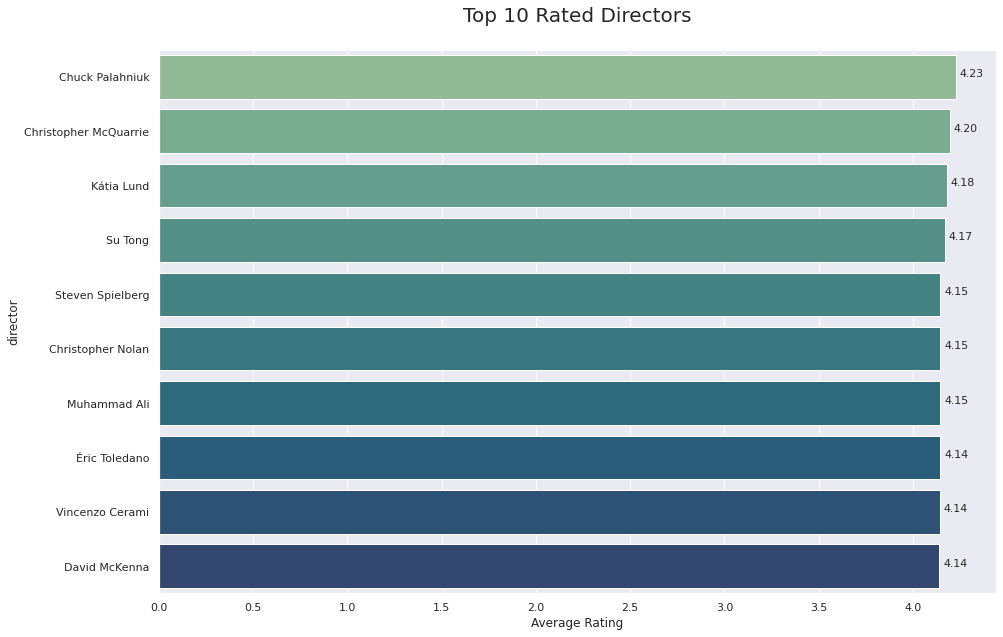

In [50]:
#joining df_train_filtered and df_imdb using the movieId column
director_rating = pd.merge(df_train_filtered,df_imdb[['movieId','director']], on='movieId', how='left')
director_rating = director_rating.groupby('director')['rating'].mean().reset_index()

#Obtaing Top 10
plot = plt.figure(figsize=(15, 10))
plt.title('Top 10 Rated Directors\n', fontsize=20)
a = sns.barplot(x='rating',
                y="director", 
                data=director_rating.sort_values(by='rating',ascending =False).head(10),
                palette='crest')

#creating horizontal label
a.set_xlabel('Average Rating')

#adding annotations to bar
for p in a.patches:
        value = '{:.2f}'.format(p.get_width())
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        a.annotate(value, (x, y),fontsize=11)
plt.show()



We get critically acclaimed directors such as Steven Spielberg, who is knowned for the "Schindler's List" which is 
        number 8 on the imdb 250 movies of all time and the 9th highest rated movie according to our filtered dataset. The top spot is held 
        by Chuck Palahniuk who is known for "Fight Club" which is also a critically acclaimed movie and is the 11th highest rated movie in our 
        dataset

#### Bottom 10 Rated Directors

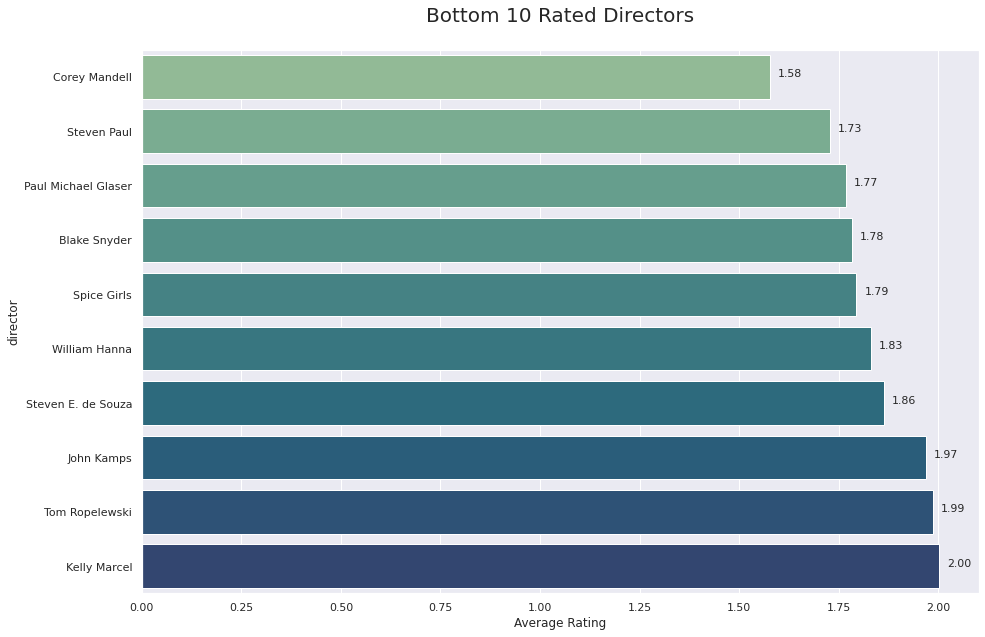

In [51]:
#bottom 10 rated directors
plot = plt.figure(figsize=(15, 10))
plt.title('Bottom 10 Rated Directors\n', fontsize=20)
a = sns.barplot(x='rating',
                y="director", 
                data=director_rating.sort_values(by='rating').head(10),
                palette='crest')

#creating horizontal label
a.set_xlabel('Average Rating')

#adding annotations to bar
for p in a.patches:
        value = '{:.2f}'.format(p.get_width())
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        a.annotate(value, (x, y),fontsize=11)
plt.show()

The worst rated director is Corey Mandell who is known for "Battlefield Earth" which is the worst rated movie according to our filtered dataset. Steven Paul is known for the movie "Baby Geniuses" and is the second worst rated director. The same applies to most of the names on this list, there's a near perfect association between the worst movies obtained earlier and the worst directors.

In [52]:
del director_rating, df_train_filtered, plot, a
gc.collect()

9472

#### Most Common Tags

In [53]:
# #top 10 movie tags by occurence
tags = df_tags.groupby(['tag'])['movieId'].count().reset_index().rename(columns={'movieId':'count'})
tags.sort_values(by='count',ascending=False).head(10)

tag  count
62208              sci-fi   8330
30252         atmospheric   6516
28231              action   5907
36136              comedy   5702
66827             surreal   5326
31464     based on a book   5079
69573        twist ending   4820
43578               funny   4738
70986  visually appealing   4526
39957            dystopia   4257

It is not surprising that the most common tags are attributes of movies that correspond to general themes such as
        "twist ending" and "based on a book" and features such as genres are expected to be common across multiple movies.

#### Least Common Tags

In [54]:
# #bottom 10 movie tags
tags.sort_values(by='count',ascending=False).tail(10)

tag  count
30493          author:Ed McBain      1
30497  author:Elizabeth Gaskell      1
30499   author:Emmanuelle Argan      1
30500     author:Erich KÃ¤stner      1
30502     author:Eugene Burdick      1
30503    author:Evan S. Connell      1
30505       author:Fannie Hurst      1
30506       author:Felix Salten      1
30507   author:Fennimore Cooper      1
73049                     카운트다운      1

Least common tags are associations with the author which could possibly apply only movies that are based on a book. And that the author is most likely to correspond to only one movie.

## Modelling phase

Here you can apply the models outline in the Intro to Recommender Notebook. You only need to apply one version 
be it Content based or Collabrative method



<a id="subsection-one"></a>
### Collaborative Filtering Models
**Advantages:**
* Can be used for any item-no feature selection needed

**Disadvantages:**
* Cold start problem - needs enough users in the system to find a match
* User/rating matrix is sparse - it is hard to find users that have rated the same items
* First Rater - can not generate recommendations for unrated items 
* Popularity bias - tends to recommend the most popular items

source: https://www.youtube.com/watch?v=6BTLobS7AU8

We are going to implement the following algorithms:

* SVD
    
    The singular value decomposition (SVD) provides another way to factorize a matrix, into singular vectors and singular values. The SVD is used widely both in the calculation of other matrix operations, such as matrix inverse, but also as a data reduction method in machine learning.
* NMF

    Non-negative matrix factorization (NMF or NNMF), also non-negative matrix approximation is a group of algorithms in multivariate analysis and linear algebra where a matrix V is factorized into (usually) two matrices W and H, with the property that all three matrices have no negative elements. This non-negativity makes the resulting matrices easier to inspect.
* NormalPredictor
 
     Algorithm predicting a random rating based on the distribution of the training set, which is assumed to be normal. The prediction $\hat{r}_{ui}$ iis generated from a normal distribution $N(\hat{\mu},\hat{\sigma}^2)$ where $\mu$ and $\hat{\sigma}^2$ are estimated from training data using Maximum Likelihood Estimations:
     $$\hat{\mu}=\frac{1}{|R_{train}|}\sum_{r_{ui}\in R_{train}}r_{ui}
     $$
   $$ \hat{\sigma}=\sqrt{\sum\frac{(r_{ui}-\hat{\mu})^2}{|R_{train}|}}$$
    
* BasenlineOnlY

    A baseline is a method that uses heuristics, simple summary statistics, randomness, or machine learning to create predictions for a dataset.
* CoClustering

    Biclustering algorithms simultaneously cluster rows and columns of a data matrix. These clusters of rows and columns are known as biclusters. Each determines a submatrix of the original data matrix with some desired properties.

#### Data Preprocessing

In [55]:
#setting rating scale
reader = Reader(rating_scale=(0.5, 5))

#parsing df_train
data = Dataset.load_from_df(df_train[['userId','movieId','rating']], reader)

trainset = data.build_full_trainset()

#creating dummy rating column
df_test.loc[:, 'rating'] = 0

#parsing df_test
test_processed = Dataset.load_from_df(df_test[['userId','movieId','rating']], reader)

#converting test dataframe to list of tuples 
NA, test = train_test_split(test_processed, test_size=1.0, shuffle = False)

#### Model Comparision

##### Evaluation Metric : Root Mean Squared Error (RMSE)
Assesses the performance of the model by using the average deviation between of the predicted outcome from the actual come. It is given by the square root of the average squared distance between the predicted outcome and the actual outcome. The range of rmse is $\mathbb{R}^{+}$ (positive real numbers). Smaller values represent a better fit. The formula is given by:
$$RMSE=\sqrt{\frac{\sum_{i}^{n}(y_i-\hat{y}_i)^2}{N}}$$
where: 
 * $y_i$ is the actual outcome of the $i^{th}$ observation
 * $\hat{y}_i$ is the predicted outcome of the $i^{th}$ observation
 * N number of observations

In [56]:
# # Apply your modelling here
def train_multi(data, model_list):
    """This functions trains multiple models
    @data : surprise dataframe
    @model_list : list of models to be trained
    returns : a dataframe containing the average rmse of each model, train_fit_time, test_fit_time
    """
    
    benchmark = []
    # Iterate over all algorithms
    for model in model_list:
        # Perform cross validation
        results = cross_validate(model, data, measures=['RMSE'], cv=3, verbose=False)

        # Get results & append algorithm name
        tmp = pd.DataFrame.from_dict(results).mean(axis=0)
        tmp = tmp.append(pd.Series([str(model).split(' ')[0].split('.')[-1]], index=['model']))
        benchmark.append(tmp)
    return pd.DataFrame(benchmark).set_index('model').sort_values('test_rmse') 
    
df_results = train_multi(data, model_list = [SVD(), 
                                             NMF(), 
                                             NormalPredictor(), 
                                             BaselineOnly(), 
                                             CoClustering()])
df_results

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


test_rmse    fit_time  test_time
model                                            
SVD               0.845879  751.701513  79.261384
BaselineOnly      0.868949   89.516924  69.395999
NMF               0.889040  765.279376  61.504147
CoClustering      0.907925  466.229563  81.605310
NormalPredictor   1.447449   25.453317  74.669530

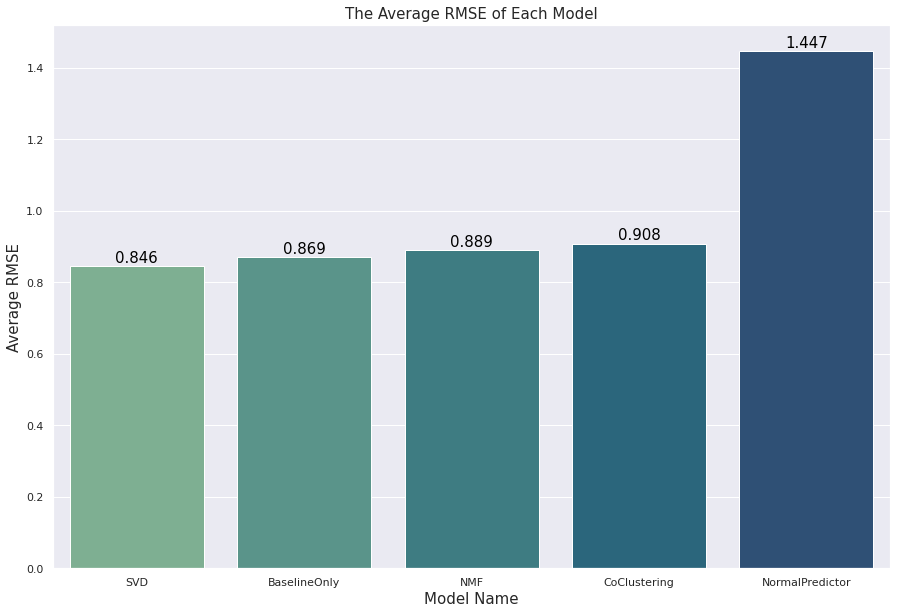

In [57]:
plot = plt.figure(figsize=(15, 10))
a = sns.barplot(x=df_results.index,y='test_rmse',data=df_results, palette='crest')
a.set_ylabel('Average RMSE',fontsize=15)
a.set_xlabel('Model Name',fontsize=15)
a.set_title('The Average RMSE of Each Model', fontsize=15)
for i in a.patches:
    # get_x pulls left or right; get_height pushes up or down
    a.text(i.get_x()+i.get_width() / 2, i.get_height()+0.01, \
            str(round(i.get_height(), 3)), fontsize=15,
                color='black',ha='center')
    

* SVD had the lowest average RMSE 
* Normal Predictor was the worst performing model. It had the highest RMSE.
* SVD, BaselineOnly, NMF, and Coclustering were not far away from each other in terms of performance

In [58]:
del df_results, test_processed, train_multi
gc.collect()

5020

#### Model Validation And Tuning
We manually tuned the different hyperparameters and the following produced the lowest rmse in the validation set. We then fitted the best model on a subset of the data and assessed the performance by looking the distribution of predicted ratings given their actual ratings.

In [59]:
train, val = train_test_split(data,test_size=0.3, random_state=2)
svd = SVD(n_epochs=40, 
          random_state=0, 
          lr_all=0.0057, 
          n_factors=400, 
          reg_all=0.025,
          init_std_dev=0.005)

svd.fit(train)

In [60]:
val_predictions = svd.test(val)
val_rating_prediction = [i.est for i in val_predictions]
df_val = pd.DataFrame(val, columns=['userId','movieId','rating'])
df_eval = pd.DataFrame({'actual_rating' : df_val['rating'], 'predicted_rating' : val_rating_prediction})

**How Good Our Algorithm at Predicting Ratings?**

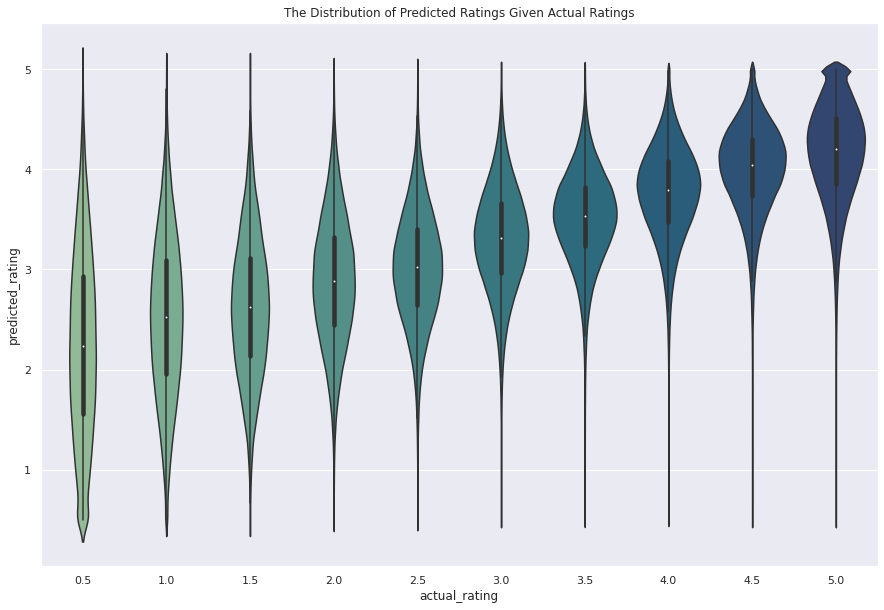

In [61]:
plt.figure(figsize=(15,10))
box = sns.violinplot(x='actual_rating',y='predicted_rating',data=df_eval, palette='crest')
box.set_title('The Distribution of Predicted Ratings Given Actual Ratings')
plt.show()

Our algorithm is not very good at predicting movies with very low ratings. As the ratings increase it does a better job, this can be seen by the narrow the distributions get as the actual rating is increasing.

In [62]:
del data,train,val_predictions, val_rating_prediction, df_val, df_eval, svd,box
gc.collect()

6128

#### Training Best Model on Full Dataset

In [63]:
svd = SVD(n_epochs=40, 
          random_state=0, 
          lr_all=0.0057, 
          n_factors=400, 
          reg_all=0.025,
          init_std_dev=0.005)

svd.fit(trainset)


#### Making Predictions

In [64]:
#getting prediction results
predictions = svd.test(test)

#retrieve estimates from prediction results
rating_prediction = [i.est for i in predictions]

# creating predictions dataframe
df_predictions = pd.DataFrame({'Id':df_test['userId'].astype(str)+'_'+df_test['movieId'].astype(str)
                               ,'rating': rating_prediction})

#### Making Submission

In [65]:
# saving final model 
# filename = 'svd_model.pkl'
# pickle.dump(svd, open(filename, 'wb'))

#saving file as csv
df_predictions.to_csv('submissio30.csv', index=False)

In [66]:
del predictions, rating_prediction, df_predictions,svd, trainset
gc.collect()

22

<a id="subsection-two"></a>
### Content Based Models
As stated earlier on, collaborative filtering algorithms suffer from the cold start phenomenon. Content based algorithms address this issue by looking at common attributes between movies and ranking them according to their relative similarities. The downside to using a content based is reduced diversity in suggestions compared to collaborative based algorithm. Note: We didn't use the content based approach to predict ratings but only used to make recommendations given the title of the movie. 


We are going to be using the following features:
* genres
* 3 leading actors
* director
* plot_keywords
* tag


#### Data Prepossessing 

We noticed that the tags dataframe contained multiple tags on the same movie but at different timestamps and so we joined all the tags with the same movie id. Before doing this, we converted all the tags to lowercase.

We merged merged df_movies,df_imdb and df_grouped_tags to have title,genre,title_cast, director, plot_keywords, and tags in one dataframe. After merging the dataframes we proceeded to clean the individual columns:

* For the title column, we removed the years and converted the all the words to lowercase. Furthermore we removed any leading and trailing white spaces from the column.  This makes makes it easy for the user to specify the title.
* For the genres column, we first ensured that everything is in string format, replaced vertical bars with spaces and finally converted all the words to lowercase.
* For the title_cast column, we ensured that everything is in string format, we joined the names and surnames of the title cast members. Created a list containing the cast members names+surname using vertical bars as separators. We then obtained the first 3 elements of the list created above and joined them using space and finally we converted everything to lowercase.
* For the directors column, we joined the names and surnames together, then removed commas and dashes from names (for names like David O. Russel and Kim Ki-duk). Finally, converted everything to lowercase.
* For plot_keywords, words were already lowercase so we replaced the vertical bars with spaces.
* We created a column that joins (soups) the columns above using spaces.





In [67]:
def tags_preprocess(df_tags):
    """This function takes in df_tags and combines the tags together based on their movieIds
    @df_tag : dataframe containing tags
    
    returns : dataframe containing joined tags
    """
    
    #convert all the tags to strings and lower case them
    df_tags['tag'] = df_tags['tag'].map(str).str.lower()
    
    #grouping tags based on movieId
    df_grouped_tags = df_tags.groupby('movieId')['tag'].apply(' '.join).reset_index()
    
    return df_grouped_tags


def threeway_merge(df1,df2,df3,column):
    """This function takes in 3 dataframe and merges them together based on the same column
     
     @df1 : first dataframe
     @df2 : second dataframe
     @df3 : third dataframe
     @column : joining column, type str
     
     returns : merged dataframe
     """
    
    #merging the first df and second df
    df_merged_prelim = pd.merge(df1, df2, on=column)
    
    #joining preliminary df to df3
    df_merged = pd.merge(df_merged_prelim,df3, on=column)
    
    return df_merged


def column_cleaner(df_movie_imdb_tag):
    """This function is for cleaning the individual columns based on their attributes
    
    @df_movie_imdb_tag : dataframe containing movie attributions
    returns : cleaned dataframe
    """
    
    """The next section is for cleaning the title column
    """
    #removing the years
    pattern = r'\(+[0-9]+\)'
    df_movie_imdb_tag['title'] = df_movie_imdb_tag['title'].apply(lambda x: re.sub(pattern, '', str(x)))
    
    #leading and trailing white spaces
    df_movie_imdb_tag['title'] = df_movie_imdb_tag['title'].apply(lambda x: x.strip())
    
    #lowercasing
    df_movie_imdb_tag['title'] = df_movie_imdb_tag['title'].str.lower()
    
    
    """This part of the function is for cleaning genres column
    """
    #replace separators with space
    pattern = r'\|'
    df_movie_imdb_tag['genres'] = df_movie_imdb_tag['genres'].apply(lambda x: re.sub(pattern, ' ', str(x)))
    
    #lowercase
    df_movie_imdb_tag['genres'] = df_movie_imdb_tag['genres'].str.lower()
    
    
    """This cleans and retrieves and the lead actor/actress from the title_cast 
    """
    #converting to string
    df_movie_imdb_tag['title_cast'] = df_movie_imdb_tag['title_cast'].apply(lambda x : str(x))
    
    #removing space
    pattern = r'\s{1,}'
    df_movie_imdb_tag['title_cast'] = df_movie_imdb_tag['title_cast'].apply(lambda x: re.sub(pattern, ' ', str(x)))
    
    #creating list of cast members based on separator
    df_movie_imdb_tag['title_cast'] = df_movie_imdb_tag['title_cast'].str.split('|')
    
    #taking first 5 itema of list
    df_movie_imdb_tag['title_cast'] =  df_movie_imdb_tag['title_cast'].apply(lambda x: x[:3])
     
    #joining the first 5 items with spaces
    df_movie_imdb_tag['title_cast'] =  df_movie_imdb_tag['title_cast'].apply(lambda x: " ".join(x))
    
    #lowercasing
    df_movie_imdb_tag['title_cast'] = df_movie_imdb_tag['title_cast'].str.lower()

    #renaming column
    df_movie_imdb_tag.rename(columns ={'title_cast':'three_lead_actors'},inplace = True)
    
    """This part of the function cleans the directors column
    """
    #removing spaces
    pattern = r'\s{1,}'
    df_movie_imdb_tag['director'] = df_movie_imdb_tag['director'].apply(lambda x: re.sub(pattern, '', str(x)))
    
    # removing commas and dashes
    pattern = r'\.|\-'
    df_movie_imdb_tag['director'] = df_movie_imdb_tag['director'].apply(lambda x: re.sub(pattern, '', x))

    #lowercasing
    df_movie_imdb_tag['director'] = df_movie_imdb_tag['director'].str.lower()
    
    """This part of the function cleans the plot_keywords
    """
    #replacing separator with spaces
    pattern = r'\|'
    df_movie_imdb_tag['plot_keywords'] = df_movie_imdb_tag['plot_keywords'].apply(lambda x: re.sub(pattern, ' ', str(x)))
    
    return df_movie_imdb_tag

def column_combiner(df,colname1,colname2,colname3,colname4,colname5):
    """This function takes in a dataframe and columns to be combined
    """
    df['documents'] = df[colname1]+" "+df[colname2]+" "+df[colname3]+" "+df[colname4]+" "+df[colname5]
    return df


In [68]:
df_grouped_tags = tags_preprocess(df_tags)
df_movie_imdb_tag =  threeway_merge(df_movies, df_imdb, df_grouped_tags, 'movieId')
df_movie_imdb_tag = column_cleaner(df_movie_imdb_tag)
df_movie_imdb_tag2 = column_combiner(df_movie_imdb_tag, 'genres','three_lead_actors', 'director','plot_keywords','tag')[['title','documents']]
df_movie_imdb_tag2.head()

title  \
0                    toy story   
1                      jumanji   
2             grumpier old men   
3            waiting to exhale   
4  father of the bride part ii   

                                           documents  
0  adventure animation children comedy fantasy to...  
1  adventure children fantasy robin williams jona...  
2  comedy romance walter matthau jack lemmon soph...  
3  comedy drama romance whitney houston angela ba...  
4  comedy steve martin diane keaton martin short ...

In [69]:
del df_grouped_tags, df_movie_imdb_tag, df_train, df_imdb, df_tags, df_movies, df_genome_tags, df_genome_scores, df_links, df_sample_submission, df_test
gc.collect()

64

#### Feature Extraction : Term Frequency Inverse Document Frequency (TF-IDF)

Term Frequency Inverse Document Frequency is a statistic that measures how important a a word is in a document while taking into consideration how many times it appears in other documents.

The reason for doing this is:
* If a word appears in a document then it is more likely to contain information about that document
* If a word is scattered throughout the whole document it is unlikely to contain information distinguishing the various documents


The calculation tf-idf can be broken into 4 parts:
1. Calculate the term frequency: 

$$ft(w,d) = \log{\left[1+f(w,d)\right]}$$
*  Where: 
 * $f(w,d)$ measures how frequently a word $w$ appears in document $d$
2. Calculate the inverse term frequency:
$$idf(w,D) = \log{\left[\frac{N}{f(w,D)}\right]}$$
* Where:
 * $N$ is the number of documents in our corpus
 * $D$ is a set containing all the documents in our corpus
 * $f(w,D)$ is the number documents that contain $w$.
3. We combine the above to form tf-idf - Term Frequency - Inverse Document Frequency:
$$tf-idf = tf(w,d)\times idf(w,D)$$

4. Finally, we get a vectorized vesion of all the documents in our corpus


Drawbacks:
* Not able to capture semantics

# <div style="width:100%;text-align: center;"> <img align=middle src="https://www.oreilly.com/library/view/applied-text-analysis/9781491963036/assets/atap_0404.png" alt="Heat beating" style="height:300px;margin-top:3rem;"> </div> 

In [70]:
# from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
feature_vector = vectorizer.fit_transform(df_movie_imdb_tag2['documents'])
feature_vector.shape

(22796, 55595)

#### Cosine Similarity

This a similarity measure that uses the angle between vectors. For this project we created a mapped our documents to vectors using tf-idf and we are going to find how similar the documents are based on their tf-idf vector representation. The cosine similarity score is in the range  [0,1] (It can not be negative since the angle between the term frequencies can not be greater than 90$^\circ$. Values close to 1 represent a high degree of similarity and values close to zero represent the opposite. The cosine similarity between two vectors $\bar{x}$ and $\bar{y}$ in p dimensional space is:
$$sim(\bar{x},\bar{y}) = \cos{(\theta)}=\frac{\bar{x}. \bar{y}}{|\bar{x}|\times|\bar{y}|}=\frac{\sum_{i}^{p}x_i\times y_i}{\sqrt{\sum_i^px_{i}^{2}}\times \sqrt{\sum_i^py_{i}^{2}}}$$
where:
 * $\bar{x}.\bar{y}$ is the dot product of $\bar{x}$ and $\bar{y}$
 * $|\bar{x}|$ and $|\bar{y}|$ are the euclidean norms (euclidean distance from origin point) of $\bar{x}$ and $\bar{y}$ respectively
 
 
<div style="width:100%;text-align: center;"> <img align=middle src="https://raw.githubusercontent.com/nkonyanihlulani/pictures/main/3d_projection.png" style="height:300px;margin-top:3rem;"> </div>
    



In [ ]:
# Compute the cosine similarity matrix
cosine_sim = linear_kernel(feature_vector, feature_vector)

#### Sample Recommendations

In [ ]:
def get_recommendations(title, cosine_sim=cosine_sim):
    
    # Get the index of the movie that matches the title
    indices = pd.DataFrame(df_movie_imdb_tag2.index, columns=['movie_index'], index=df_movie_imdb_tag2['title'])
    indices = indices[~indices.index.duplicated()]
    if title not in indices.index:
        return print("Oops! Are you sure you have the right name?")
    else:
        idx = indices['movie_index'][title]

        # Get the pairwsie similarity scores of all movies with that movie
        sim_scores = list(enumerate(cosine_sim[idx]))

        # Sort the movies based on the similarity scores
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # Get the scores of the 10 most similar movies
        sim_scores = sim_scores[1:11]

        # Get the movie indices
        movie_indices = [i[0] for i in sim_scores]

        # Return the top 10 most similar movies
        return df_movie_imdb_tag2['title'].iloc[movie_indices]

Now time to make some recommendations

In [ ]:
get_recommendations('prestige, the')

# Conclusion

Our mission was to create a recommender system. Wen created 2 models algorithms, one based of colaborative filtering and another one based on cantent filtering. For colaborative filtering we fitted several models, and svd produced the lowest root mean squared error. We tuned our model and received an rsme of 0.786. We used our content based algorithm whenever the user provides a movie title and it was able to recommend similar movies with great accuracy.